In [12]:
import math
import pandas as pd
import numpy as np
from numpy import asarray
np.random.seed(0)
import matplotlib.pyplot as plt
from collections import defaultdict
from sklearn import metrics
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error 
from sklearn.model_selection import train_test_split
from numpy import absolute
from pandas import read_csv
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE

In [13]:
dataset = pd.read_csv(r"C:\Users\Mukesh\Desktop\Fall 2022 Applications\Admits\UCR\Fall 2022\DMT\Customer Acquisition Cost Prediction\DMT_dataset.csv")

In [14]:
encoder = LabelEncoder()
for item in dataset:
    dataset[item] = encoder.fit_transform(dataset[item])

In [15]:
class TreeBooster():
 
    def __init__(self, X, g, h, params, max_depth, idxs=None):
        self.params = params
        self.max_depth = max_depth
        assert self.max_depth >= 0, 'max_depth must be nonnegative'
        self.min_child_weight = params['min_child_weight'] \
            if params['min_child_weight'] else 1.0
        self.reg_lambda = params['reg_lambda'] if params['reg_lambda'] else 1.0
        self.gamma = params['gamma'] if params['gamma'] else 0.0
        self.colsample_bynode = params['colsample_bynode'] \
            if params['colsample_bynode'] else 1.0
        if isinstance(g, pd.Series): g = g.values
        if isinstance(h, pd.Series): h = h.values
        if idxs is None: idxs = np.arange(len(g))
        self.X, self.g, self.h, self.idxs = X, g, h, idxs
        self.n, self.c = len(idxs), X.shape[1]
        self.value = -g[idxs].sum() / (h[idxs].sum() + self.reg_lambda) # Eq (5)
        self.best_score_so_far = 0.
        if self.max_depth > 0:
            self._maybe_insert_child_nodes()

    def _maybe_insert_child_nodes(self):
        for i in range(self.c): self._find_better_split(i)
        if self.is_leaf: return
        x = self.X.values[self.idxs,self.split_feature_idx]
        left_idx = np.nonzero(x <= self.threshold)[0]
        right_idx = np.nonzero(x > self.threshold)[0]
        self.left = TreeBooster(self.X, self.g, self.h, self.params, 
                                self.max_depth - 1, self.idxs[left_idx])
        self.right = TreeBooster(self.X, self.g, self.h, self.params, 
                                 self.max_depth - 1, self.idxs[right_idx])

    @property
    def is_leaf(self): return self.best_score_so_far == 0.
    
    def _find_better_split(self, feature_idx):
        x = self.X.values[self.idxs, feature_idx]
        g, h = self.g[self.idxs], self.h[self.idxs]
        sort_idx = np.argsort(x)
        sort_g, sort_h, sort_x = g[sort_idx], h[sort_idx], x[sort_idx]
        sum_g, sum_h = g.sum(), h.sum()
        sum_g_right, sum_h_right = sum_g, sum_h
        sum_g_left, sum_h_left = 0., 0.

        for i in range(0, self.n - 1):
            g_i, h_i, x_i, x_i_next = sort_g[i], sort_h[i], sort_x[i], sort_x[i + 1]
            sum_g_left += g_i; sum_g_right -= g_i
            sum_h_left += h_i; sum_h_right -= h_i
            if sum_h_left < self.min_child_weight or x_i == x_i_next:continue
            if sum_h_right < self.min_child_weight: break

            gain = 0.5 * ((sum_g_left**2 / (sum_h_left + self.reg_lambda))
                            + (sum_g_right**2 / (sum_h_right + self.reg_lambda))
                            - (sum_g**2 / (sum_h + self.reg_lambda))
                            ) - self.gamma/2 # Eq(7) in the xgboost paper
            if gain > self.best_score_so_far: 
                self.split_feature_idx = feature_idx
                self.best_score_so_far = gain
                self.threshold = (x_i + x_i_next) / 2
                
    def predict(self, X):
        return np.array([self._predict_row(row) for i, row in X.iterrows()])

    def _predict_row(self, row):
        if self.is_leaf: 
            return self.value
        child = self.left if row[self.split_feature_idx] <= self.threshold \
            else self.right
        return child._predict_row(row)

In [16]:
class XGBoostModel():
    '''XGBoost from Scratch
    '''
    
    def __init__(self, params, random_seed=None):
        self.params = defaultdict(lambda: None, params)
        self.subsample = self.params['subsample'] \
            if self.params['subsample'] else 1.0
        self.learning_rate = self.params['learning_rate'] \
            if self.params['learning_rate'] else 0.3
        self.base_prediction = self.params['base_score'] \
            if self.params['base_score'] else 0.5
        self.max_depth = self.params['max_depth'] \
            if self.params['max_depth'] else 5
        self.rng = np.random.default_rng(seed=random_seed)
                
    def fit(self, X, y, objective, num_boost_round, verbose=False):
        current_predictions = self.base_prediction * np.ones(shape=y.shape)
        self.boosters = []
        for i in range(num_boost_round):
            gradients = objective.gradient(y, current_predictions)
            hessians = objective.hessian(y, current_predictions)
            sample_idxs = None if self.subsample == 1.0 \
                else self.rng.choice(len(y), 
                                     size=math.floor(self.subsample*len(y)), 
                                     replace=False)
            booster = TreeBooster(X, gradients, hessians, 
                                  self.params, self.max_depth, sample_idxs)
            current_predictions += self.learning_rate * booster.predict(X)
            self.boosters.append(booster)
            if verbose: 
                print(f'[{i}] train loss = {objective.loss(y, current_predictions)}')
            
    def predict(self, X):
        return (self.base_prediction + self.learning_rate 
                * np.sum([booster.predict(X) for booster in self.boosters], axis=0))

In [17]:
class SquaredErrorObjective():
    def loss(self, y, pred): return np.mean((y - pred)**2)
    def gradient(self, y, pred): return pred - y
    def hessian(self, y, pred): return np.ones(len(y))

In [49]:
features=dataset[dataset.columns[0:len(dataset.columns)-1]]
label = dataset["cost"]
X_train, X_test, y_train, y_test = train_test_split(features, label,
                      test_size = 0.3, random_state = 123)
params = {
    'learning_rate': 0.1,
    'max_depth': 5,
    'subsample': 0.8,
    'reg_lambda': 1.5,
    'gamma': 0.0,
    'min_child_weight': 25,
    'base_score': 0.0,
    'tree_method': 'exact',
}
num_boost_round = 50

# train the from-scratch XGBoost model
model_scratch = XGBoostModel(params, random_seed=42)
model_scratch.fit(X_train, y_train, SquaredErrorObjective(), num_boost_round)

# train the library XGBoost model
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)
model_xgb = xgb.train(params, dtrain, num_boost_round)

In [50]:
pred_scratch = model_scratch.predict(X_test)
pred_xgb = model_xgb.predict(dtest)

In [51]:
print(f"Scratch Predicted Values:{pred_scratch}")
print(f"Scratch Predicted Values:{pred_xgb}")
print(f"Actual Values:{y_test.values}")
print()
print("Scratch Model R2 Score : % f" %(metrics.r2_score(test_y, pred_scratch)))
print("SciKit XGBoost Model R2 Score : % f" %(metrics.r2_score(test_y, pred_xgb)))
print()
print("Scratch Model RMSE Score : % f" %(metrics.mean_squared_error(test_y, pred_scratch, squared=False)))
print("SciKit XGBoost Model RMSE Score : % f" %(metrics.mean_squared_error(test_y, pred_xgb, squared=False)))
print()
print("Scratch Model MAE Score : % f" %(metrics.mean_absolute_error(test_y, pred_scratch)))
print("SciKit XGBoost Model MAE Score : % f" %(metrics.mean_absolute_error(test_y, pred_xgb)))
print()
print("Scratch Model MSE Score : % f" %(metrics.mean_squared_error(test_y, pred_scratch)))
print("SciKit XGBoost Model MSE Score : % f" %(metrics.mean_squared_error(test_y, pred_xgb)))

Scratch Predicted Values:[131.80393014 137.17680156 133.52204291 ... 113.8782217   49.48964148
  63.38493698]
Scratch Predicted Values:[128.05173  143.72859  135.04008  ... 117.157906  47.42313   64.79468 ]
Actual Values:[157  27 127 ... 103  22  36]

Scratch Model R2 Score :  0.771810
SciKit XGBoost Model R2 Score :  0.782837

Scratch Model RMSE Score :  46.228215
SciKit XGBoost Model RMSE Score :  45.097381

Scratch Model MAE Score :  36.075557
SciKit XGBoost Model MAE Score :  35.872762

Scratch Model MSE Score :  2137.047894
SciKit XGBoost Model MSE Score :  2033.773763


In [43]:
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
#
# Create an instance of StratifiedKFold which can be used to get indices of different training and test folds
#
strtfdKFold = StratifiedKFold(n_splits=10)
kfold = strtfdKFold.split(X_train, y_train)
scores = []
#
#
#
model_scratch = XGBoostModel(params, random_seed=42)
for k, (train, test) in enumerate(kfold):
    model_scratch.fit(X_train.iloc[train, :], y_train.iloc[train],SquaredErrorObjective(), num_boost_round)
    pred_scratch = model_scratch.predict(X_train.iloc[test, :])
    score = metrics.r2_score(pred_scratch, y_train.iloc[test])
    scores.append(score)
    print('Fold: %2d, Training/Test Split Distribution: %s, Accuracy: %.3f' % (k+1, np.bincount(y_train.iloc[train]), score))
 
print('\n\nCross-Validation accuracy: %.3f +/- %.3f' %(np.mean(scores), np.std(scores)))

C:\Users\Mukesh\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Fold:  1, Training/Test Split Distribution: [140 164 271  29  78  87 213  20  48 102 180  87 122  15 122 105 108 206
 311 159  76 112  97  88 197 156 122   9 203 154  68  36  98 184 175 458
 133  19  86  82  90  75 133 107 103  92 157 129  92 154  91 322  87  87
  91 266  78  68 116  63 167  18  96 117 153  73 146 167   9  13  25 315
  71 455 279 136  12 110  78  22 131 113  16  21 124  55 193  16  92 154
  85 109 169  50  11 227  13   9  13 215 179  75 288 411  82 146 134 100
 121 144   8 153  97 250  79  65  21 283 345  40 157 202 173 223 127 125
 345 170 352 192 146 101 113  17 180  18  71  37  19 180  90  14 337 158
 190  29  84  24 129  64  84 103 320 345  91  78  92 181   8  85  41   8
 544  90 156  93  99  10 101 117  24 172  95 210  88  84 102 118 181 154
  34 181   9  34 121  43  72  63 108  94  45  22  22 160 127 255 114  71
 100  84  82  30  15  91 118  23 284  30 138 314  27 100  76  92  71  14
  96 297  90  83  25  17  23  22  14  84  25 132  14  21 128  81 172  89
 160  5

In [44]:
class RootSquaredErrorObjective():
    def loss(self, y, pred): return np.sqrt(np.mean((y - pred)**2))
    def gradient(self, y, pred): return pred - y
    def hessian(self, y, pred): return np.ones(len(y))

strtfdKFold = StratifiedKFold(n_splits=10)
kfold = strtfdKFold.split(X_train, y_train)
rmse_scores = []
#
#
#
model_scratch = XGBoostModel(params, random_seed=42)
for k, (train, test) in enumerate(kfold):
    model_scratch.fit(X_train.iloc[train, :], y_train.iloc[train],RootSquaredErrorObjective(), num_boost_round)
    pred_scratch = model_scratch.predict(X_train.iloc[test, :])
    score = metrics.mean_squared_error(pred_scratch, y_train.iloc[test], squared=False)
    rmse_scores.append(score)
    print('Fold: %2d, Accuracy: %.3f' % (k+1, score))
 
print('\n\nCross-Validation accuracy: %.3f +/- %.3f' %(np.mean(rmse_scores), np.std(rmse_scores)))

C:\Users\Mukesh\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Fold:  1, Training/Test Split Distribution: [140 164 271  29  78  87 213  20  48 102 180  87 122  15 122 105 108 206
 311 159  76 112  97  88 197 156 122   9 203 154  68  36  98 184 175 458
 133  19  86  82  90  75 133 107 103  92 157 129  92 154  91 322  87  87
  91 266  78  68 116  63 167  18  96 117 153  73 146 167   9  13  25 315
  71 455 279 136  12 110  78  22 131 113  16  21 124  55 193  16  92 154
  85 109 169  50  11 227  13   9  13 215 179  75 288 411  82 146 134 100
 121 144   8 153  97 250  79  65  21 283 345  40 157 202 173 223 127 125
 345 170 352 192 146 101 113  17 180  18  71  37  19 180  90  14 337 158
 190  29  84  24 129  64  84 103 320 345  91  78  92 181   8  85  41   8
 544  90 156  93  99  10 101 117  24 172  95 210  88  84 102 118 181 154
  34 181   9  34 121  43  72  63 108  94  45  22  22 160 127 255 114  71
 100  84  82  30  15  91 118  23 284  30 138 314  27 100  76  92  71  14
  96 297  90  83  25  17  23  22  14  84  25 132  14  21 128  81 172  89
 160  5

In [45]:
strtfdKFold = StratifiedKFold(n_splits=10)
kfold = strtfdKFold.split(X_train, y_train)
mse_scores = []
#
#
#
model_scratch = XGBoostModel(params, random_seed=42)
for k, (train, test) in enumerate(kfold):
    model_scratch.fit(X_train.iloc[train, :], y_train.iloc[train],SquaredErrorObjective(), num_boost_round)
    pred_scratch = model_scratch.predict(X_train.iloc[test, :])
    score = metrics.mean_squared_error(pred_scratch, y_train.iloc[test])
    mse_scores.append(score)
    print('Fold: %2d, Accuracy: %.3f' % (k+1, score))
 
print('\n\nCross-Validation accuracy: %.3f +/- %.3f' %(np.mean(mse_scores), np.std(mse_scores)))

C:\Users\Mukesh\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Fold:  1, Training/Test Split Distribution: [140 164 271  29  78  87 213  20  48 102 180  87 122  15 122 105 108 206
 311 159  76 112  97  88 197 156 122   9 203 154  68  36  98 184 175 458
 133  19  86  82  90  75 133 107 103  92 157 129  92 154  91 322  87  87
  91 266  78  68 116  63 167  18  96 117 153  73 146 167   9  13  25 315
  71 455 279 136  12 110  78  22 131 113  16  21 124  55 193  16  92 154
  85 109 169  50  11 227  13   9  13 215 179  75 288 411  82 146 134 100
 121 144   8 153  97 250  79  65  21 283 345  40 157 202 173 223 127 125
 345 170 352 192 146 101 113  17 180  18  71  37  19 180  90  14 337 158
 190  29  84  24 129  64  84 103 320 345  91  78  92 181   8  85  41   8
 544  90 156  93  99  10 101 117  24 172  95 210  88  84 102 118 181 154
  34 181   9  34 121  43  72  63 108  94  45  22  22 160 127 255 114  71
 100  84  82  30  15  91 118  23 284  30 138 314  27 100  76  92  71  14
  96 297  90  83  25  17  23  22  14  84  25 132  14  21 128  81 172  89
 160  5

In [46]:
class AbsoluteErrorObjective():
    def loss(self, y, pred): return np.mean((y - pred))
    def gradient(self, y, pred): return pred - y
    def hessian(self, y, pred): return np.ones(len(y))

strtfdKFold = StratifiedKFold(n_splits=10)
kfold = strtfdKFold.split(X_train, y_train)
mae_scores = []
#
#
#
model_scratch = XGBoostModel(params, random_seed=42)
for k, (train, test) in enumerate(kfold):
    model_scratch.fit(X_train.iloc[train, :], y_train.iloc[train],AbsoluteErrorObjective(), num_boost_round)
    pred_scratch = model_scratch.predict(X_train.iloc[test, :])
    score = metrics.mean_absolute_error(pred_scratch, y_train.iloc[test])
    mae_scores.append(score)
    print('Fold: %2d, Accuracy: %.3f' % (k+1, score))
 
print('\n\nCross-Validation accuracy: %.3f +/- %.3f' %(np.mean(mae_scores), np.std(mae_scores)))

C:\Users\Mukesh\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:666: UserWarning: The least populated class in y has only 8 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"


Fold:  1, Training/Test Split Distribution: [140 164 271  29  78  87 213  20  48 102 180  87 122  15 122 105 108 206
 311 159  76 112  97  88 197 156 122   9 203 154  68  36  98 184 175 458
 133  19  86  82  90  75 133 107 103  92 157 129  92 154  91 322  87  87
  91 266  78  68 116  63 167  18  96 117 153  73 146 167   9  13  25 315
  71 455 279 136  12 110  78  22 131 113  16  21 124  55 193  16  92 154
  85 109 169  50  11 227  13   9  13 215 179  75 288 411  82 146 134 100
 121 144   8 153  97 250  79  65  21 283 345  40 157 202 173 223 127 125
 345 170 352 192 146 101 113  17 180  18  71  37  19 180  90  14 337 158
 190  29  84  24 129  64  84 103 320 345  91  78  92 181   8  85  41   8
 544  90 156  93  99  10 101 117  24 172  95 210  88  84 102 118 181 154
  34 181   9  34 121  43  72  63 108  94  45  22  22 160 127 255 114  71
 100  84  82  30  15  91 118  23 284  30 138 314  27 100  76  92  71  14
  96 297  90  83  25  17  23  22  14  84  25 132  14  21 128  81 172  89
 160  5

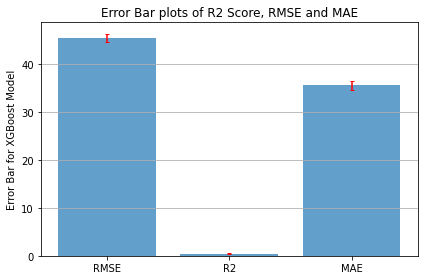

In [59]:
scores_rmse = absolute(rmse_scores)
scores_mse = absolute(mse_scores)
scores_r2 = absolute(scores)
scores_mae = absolute(mae_scores)

#Define the plot
labels = ['RMSE', 'R2', 'MAE']
x_pos = np.arange(len(labels))
CTEs = [absolute(scores_rmse.mean()), absolute(scores_r2.mean()), absolute(scores_mae.mean())]
error = [absolute(scores_rmse.std()), absolute(scores_r2.std()), absolute(scores_mae.std())]
fig, ax = plt.subplots()
ax.bar(x_pos, CTEs,
       yerr=error,
       align='center',
       alpha=0.7,
       ecolor='red',
       capsize=2)
ax.set_ylabel('Error Bar for XGBoost Model')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels)
ax.set_title('Error Bar plots of R2 Score, RMSE and MAE')
ax.yaxis.grid(True)

# Save the figure and show
plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()

In [60]:
#Print metric values
print('R2 score  :  %.8f (SD: %.8f)' % (scores_r2.mean(), scores_r2.std()) )
print('RMSE score:  %.8f (SD: %.8f)' % (scores_rmse.mean(), scores_rmse.std()) )
print('MSE score : %.8f (SD: %.8f)' % (scores_mse.mean(), scores_mse.std()) )
print('MAE score :  %.8f (SD: %.8f)' % (scores_mae.mean(), scores_mae.std()) )

R2 score  :  0.47057685 (SD: 0.03232551)
RMSE score:  45.40821777 (SD: 0.89761438)
MSE score : 2062.71195275 (SD: 81.96884040)
MAE score :  35.55510148 (SD: 0.91426688)


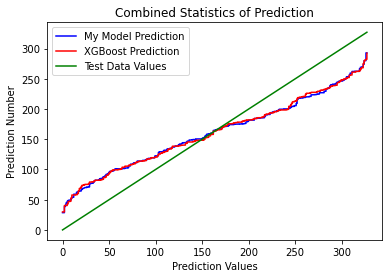

In [56]:
pred_scratch.sort()
pred_xgb.sort()
test = y_test.values
test.sort()
y1 = pred_scratch
y2 = pred_xgb
x = test

plt.plot(x, y1, "-b", label="My Model Prediction")
plt.plot(x, y2, "-r", label="XGBoost Prediction")
plt.plot(x, x, "-g", label="Test Data Values")
plt.title("Combined Statistics of Prediction")
plt.xlabel("Prediction Values")
plt.ylabel("Prediction Number")
plt.legend(loc="upper left")
plt.show()

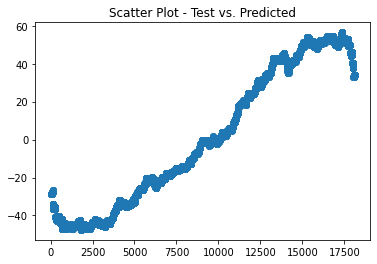

In [62]:
plt.plot(test - pred_scratch, marker='o', linestyle='')
plt.title("Scatter Plot - Test vs. Predicted")
plt.show()

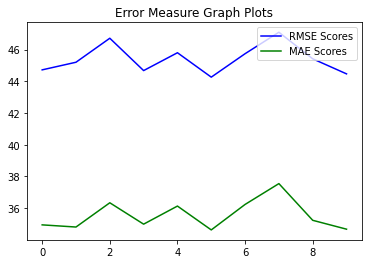

In [66]:
plt.plot(scores_rmse, "-b", label="RMSE Scores")
plt.plot(scores_mae, "-g", label="MAE Scores")
plt.title("Error Measure Graph Plots")
plt.legend(loc="upper right")
plt.show()

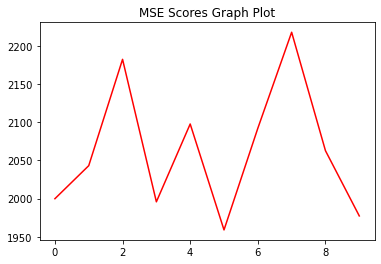

In [72]:
plt.plot(scores_mse, "-r", label="MSE Scores")
plt.title("MSE Scores Graph Plot")
plt.show()

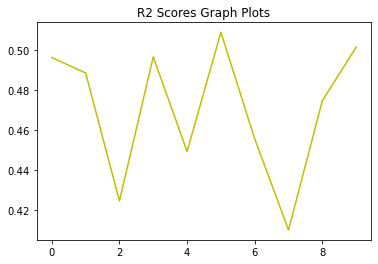

In [71]:
plt.plot(scores_r2, "-y", label="R2 Scores")
plt.title("R2 Scores Graph Plots")
plt.show()